In [1]:
import numpy as np
import Agents
from sweeper import Sweeper
from training_engine import ConfigDictConverter, test_policy_evaluation_error
import pickle
import matplotlib.pyplot as plt
import offline_data

np.set_printoptions(precision=3, linewidth=300, suppress=True)

i_run = 0
sweeper = Sweeper('config/config_test.json')

# do some training here
config_dict = sweeper.parse(i_run)
cfg = ConfigDictConverter(config_dict)

chkpt_idx = 0
model_path = "mountaincar"

td_agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)
td_model_path = 'test_save_' + model_path + '/td_0_model_{chkpt_idx}.pyt'  # not an f-string so we can vary chkpt_idx later
# td_agent.load_model(f'test_save_mountain/td_0_model_{chkpt_idx}.pyt')


mc_agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)
mc_model_path = 'test_save_' + model_path + '/mc_0_model_{chkpt_idx}.pyt'
# mc_agent.load_model(f'test_save_mountain/mc_0_model_{chkpt_idx}.pyt')

path_env = model_path
path = 'data_generation/'
# test_states = np.load(path + 'Cartpole_test_states_0.npy')
# test_values = np.load(path + 'Cartpole_test_values_0.npy')
test_states = offline_data.load_test_states(path, path_env)  
test_values = offline_data.load_test_values(path, path_env)





### Learning curves

In [2]:
### Compute linear regression error

# print(len(test_values), all_features.shape)
# print(agent.get_prediction(test_states[0]), test_values[0])
def test_error(agent, verbose=True):
    # preds = agent.get_prediction(test_states)
    # print(preds)
    # rmse = np.sqrt(np.mean((preds - test_values)**2))
    rmse = test_policy_evaluation_error(agent, test_states, test_values)
    if verbose:
        print("test error", rmse)
    return rmse


def linear_regression_test(agent, verbose=True):
    all_features = agent.get_features(test_states)
    param, squared_error, rank, _ = np.linalg.lstsq(all_features, test_values, rcond=None)
    
    linear_test_error = np.sqrt(np.mean( (np.dot(all_features, param) - test_values)**2))
    if verbose:
        print("feature rank", rank)
        print("linear test error", linear_test_error)
    return rank, linear_test_error
    

def compare_TD_and_MC(chkpt_idx, verbose=True):
    td_agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)
    td_agent.load_model(td_model_path.format(chkpt_idx=chkpt_idx))

    mc_agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)
    mc_agent.load_model(mc_model_path.format(chkpt_idx=chkpt_idx))
    
    if verbose:
        print("--- TD Agent --- checkpoint", chkpt_idx)
    test_error_td = test_error(td_agent, verbose)
    rank_td, lin_test_error_td = linear_regression_test(td_agent, verbose)
    if verbose:
        print("--- MC Agent ---")
    test_error_mc = test_error(mc_agent, verbose)
    rank_mc, lin_test_error_mc = linear_regression_test(mc_agent, verbose)
    return test_error_td, rank_td, lin_test_error_td, test_error_mc, rank_mc, lin_test_error_mc

_ = compare_TD_and_MC(199)
# _ = compare_TD_and_MC(2099)

--- TD Agent --- checkpoint 199
test error 62.52619896217162
feature rank 45
linear test error 9.895315428586663
--- MC Agent ---
test error 16.409978661262503
feature rank 55
linear test error 10.121883056356678


[   0   99  199  299  399  499  599  699  799  899  999 1099 1199 1299 1399 1499 1599 1699 1799 1899 1999 2099 2199 2299 2399 2499 2599 2699 2799 2899 2999 3099 3199 3299 3399 3499 3599 3699 3799 3899 3999 4099 4199 4299 4399 4499 4599 4699 4799 4899 4999]


Text(0.5, 1.0, 'Rank learning curve')

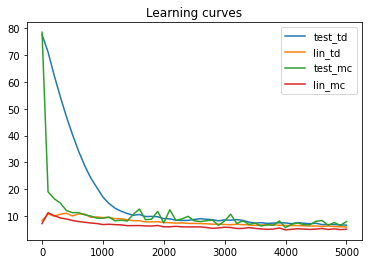

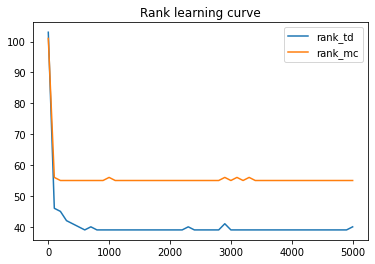

In [3]:
# idxs = np.arange(0, 100)*5 + 4
idxs = np.arange(0, 50)*100 + 99

idxs = np.insert(idxs,0,0)
print(idxs)
results = []
for idx in idxs:
    results.append(compare_TD_and_MC(idx, verbose=False))
results = np.array(results)

plt.plot(idxs, results[:,0], label='test_td')
plt.plot(idxs, results[:,2], label='lin_td')

plt.plot(idxs, results[:,3], label='test_mc')
plt.plot(idxs, results[:,5], label='lin_mc')
plt.legend()
plt.title("Learning curves")

plt.figure()
plt.plot(idxs, results[:,1], label='rank_td')
plt.plot(idxs, results[:,4], label='rank_mc')
plt.legend()
plt.title("Rank learning curve")


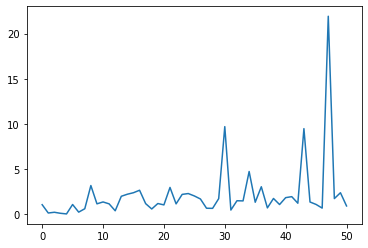

In [4]:
with open("test_save_{}/td_0.pkl".format(model_path), 'rb') as file:
    td_results = pickle.load(file)
# plt.plot(td_results['test_error'])
plt.plot(td_results['loss'])
# print(td_results.keys())
# print(results['test_error'])
with open("test_save_{}/mc_0.pkl".format(model_path), 'rb') as file:
    mc_results = pickle.load(file)
    
# plt.plot(mc_results['test_error'])
# plt.plot(mc_results['loss'])
# plt.ylim(0,1000)

### Ehsan's alignment

In [54]:
### Compute alignment as in Ehsan's paper
def compute_alignment(singular_vectors, y, singular_values, threshold):
    ''' Computes the alignment for the specified threshold 
    We rescale the singular values by the largest singular value. This ensures that the convergence rate
    bounds are comparable. See Ehsan's paper.'''
    scaled_singular_values = singular_values / np.max(singular_values)
    threshold_idx = np.searchsorted(-scaled_singular_values, -threshold)  # gives first index where value exceeds threshold
    alignments = np.transpose(singular_vectors[:, 0:threshold_idx]).dot(y)
    return np.sum(alignments**2)

chkpt_idx = None
def plot_alignment(chkpt_idx, model):
    if model == 'td':
        agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)
        agent.load_model(td_model_path.format(chkpt_idx=chkpt_idx))
    elif model == 'mc':
        agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)
        agent.load_model(mc_model_path.format(chkpt_idx=chkpt_idx))
    elif model == 'random':
        agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)  # random untrained agent

    features = agent.get_features(test_states, add_bias=True)

    print("max feature", np.max(features), "max l2", np.max(np.linalg.norm(features,ord=2, axis=1)),
         "max l1", np.max(np.linalg.norm(features,ord=1, axis=1)))

    # scaled_features = features #/  np.max(np.linalg.norm(features,ord=2, axis=1)) # / np.max(features)

    singular_vectors, singular_values, _ = np.linalg.svd(features)
    print("singular values", singular_values[0:20])

    alignments = []
    thresholds = np.linspace(0, 1.01, 100)

    for x in thresholds:
        alignments.append(compute_alignment(singular_vectors, test_values/100, singular_values, x))
    
    print("Avg alignment", np.mean(alignments))
    plt.plot(thresholds, alignments, label=model+str(chkpt_idx))
    # plt.ylim(150,350)

# how to summarize these 

max feature 3.177004 max l2 10.321311 max l1 68.41713
singular values [131.205  54.073  29.4    18.342  11.899   9.282   7.402   5.905   5.177   3.569   3.435   3.16    2.382   2.178   1.935   1.818   1.637   1.432   1.264   1.194]
Avg alignment 196.29284288202405
max feature 3.1374693 max l2 7.405899 max l1 32.540527
singular values [78.847 41.266 20.549 15.577  9.033  7.858  6.339  4.917  3.188  2.588  2.439  1.885  1.752  1.538  1.306  1.246  1.156  0.995  0.958  0.893]
Avg alignment 223.61515855210146
max feature 3.2336564 max l2 7.67773 max l1 33.741596
singular values [80.593 41.795 21.189 15.828  9.02   8.054  6.467  4.869  3.201  2.742  2.591  1.952  1.743  1.502  1.421  1.275  1.204  1.027  0.973  0.894]
Avg alignment 223.94480390039817
max feature 6.848738 max l2 13.087081 max l1 44.25468
singular values [213.827  68.497  25.739  17.543  10.788   9.911   5.577   4.644   3.778   2.898   2.207   2.104   1.647   1.408   1.253   1.005   0.926   0.741   0.709   0.573]
Avg alignmen

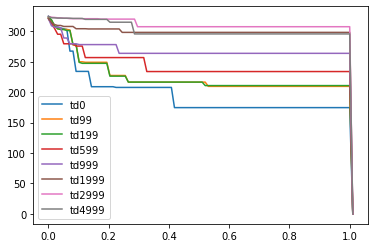

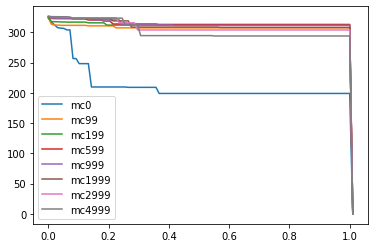

In [56]:
idxs = [0,99, 199, 599, 999, 1999, 2999, 4999]
# idxs = [0, 19, 39, 99, 499, 999]
for idx in idxs:
    plot_alignment(idx, 'td')
plt.legend()
plt.figure()
for idx in idxs:
    plot_alignment(idx, 'mc')
plt.legend()

max feature 3.172454 max l2 10.367496 max l1 69.35951
singular values [135.07   57.652  30.41   19.157  15.36   10.311   7.299   6.24    5.351   3.903   3.29    2.888   2.592   2.368   1.849   1.643   1.545   1.364   1.271   1.165]
Avg alignment 208.64396681731358


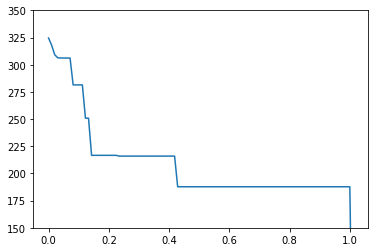

In [13]:
plot_alignment(0, model='random')

In [12]:
# Generate true state values

_, state_values = gw.policy_evaluation(gw.generate_entire_cover_policy())


1 0.5
2 0.45
3 0.36935999999999997
4 0.31029155999999997
5 0.26040556512000007
6 0.21831173016768013
7 0.18282427508044818
8 0.15021913893690073
9 0.12407209880192255
10 0.10118201585199194
11 0.08238399536504923
12 0.06875542829056158
13 0.0572874627191442
14 0.047649077007239915
15 0.03955829794729167
16 0.032114294271008065
17 0.026193434960814846
18 0.015319639163227206
19 0.013460350139602173
20 0.006354963132112396
21 0.0037204741455251766
22 0.0016166218057224457
23 0.0007699919816460399
24 0.0003151189868519366
25 0.0001343260536730284
26 5.2582810616041975e-05
27 2.0942455545375216e-05
28 7.925953451809464e-06
29 3.0178187485074837e-06
30 1.1127286225764976e-06
31 4.1055123456423814e-07


### Checking predictions on gridworld (with gif)

In [60]:
### Check predictions
# for gridworld
import Envs
gw = Envs.WallGridWorldEnv()

chkpt_idx = 4

mc_agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)

mc_agent.load_model(mc_model_path.format(chkpt_idx=chkpt_idx))
td_agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)

td_agent.load_model(td_model_path.format(chkpt_idx=chkpt_idx))


agent = td_agent

# test_state = np.array([0,0]) / np.array([6,6])
# pred = mc_agent.get_prediction(test_state)
def agent_predictions(agent):
    predictions = np.zeros((6,6))
    for i in range(6):
        for j in range(6):
            predictions[i,j] = agent.get_prediction(gw.preprocess_state([i,j]))
        
    # print(predictions)

    return predictions
error_td = agent_predictions(td_agent) - state_values
error_mc = agent_predictions(mc_agent) - state_values

print("-- TD Agent --")
print(error_td)
print("-- MC Agent --")
print(error_mc)



-- TD Agent --
[[-0.478 -0.576 -0.757 -0.858 -0.96  -1.172]
 [-0.493 -0.671 -0.826 -0.859 -0.924 -1.092]
 [-0.462 -0.731 -0.99  -0.957 -1.059 -1.209]
 [-1.078 -1.235 -1.459 -1.435 -1.372 -1.381]
 [-1.332 -1.496 -1.693 -1.694 -1.644 -1.622]
 [-1.627 -1.802 -1.944 -1.946 -1.888 -1.839]]
-- MC Agent --
[[-0.068 -0.224 -0.271 -0.312 -0.399 -0.517]
 [-0.119 -0.113 -0.086 -0.024 -0.006 -0.069]
 [-0.096 -0.008  0.125  0.175  0.181  0.17 ]
 [-0.557 -0.387 -0.12   0.107  0.22   0.301]
 [-0.57  -0.362 -0.128  0.138  0.324  0.409]
 [-0.561 -0.346 -0.096  0.103  0.342  0.484]]


[Text(0.5, 1.0, 'MC prediction errors')]

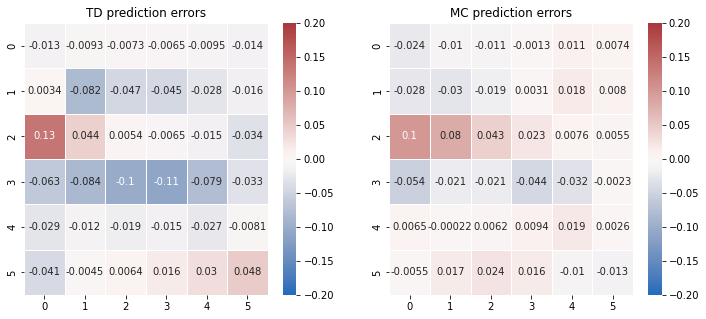

In [64]:
import seaborn as sns

# import matplotlib.pylab as plt

f, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(agent_predictions(td_agent) - state_values, linewidth=0.5, vmin=-0.2, vmax=0.2, 
            annot=error_td,
            cmap=sns.color_palette("vlag", as_cmap=True),
            ax=axes[0]).set(title='TD prediction errors')

sns.heatmap(agent_predictions(mc_agent) - state_values, linewidth=0.5, vmin=-0.2, vmax=0.2,
            annot=error_mc,
            cmap=sns.color_palette("vlag", as_cmap=True),
            ax=axes[1]).set(title='MC prediction errors')


# plt.show()

In [66]:

idxs = np.arange(0, 100)*5 + 4
idxs = np.insert(idxs,0,0)
for chkpt_idx in idxs:
    print(chkpt_idx)
    mc_agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)
    mc_agent.load_model(mc_model_path.format(chkpt_idx=chkpt_idx))
    td_agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)
    td_agent.load_model(td_model_path.format(chkpt_idx=chkpt_idx))
    error_td = agent_predictions(td_agent) - state_values
    error_mc = agent_predictions(mc_agent) - state_values

    f, axes = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(agent_predictions(td_agent) - state_values, linewidth=0.5, vmin=-0.2, vmax=0.2, 
                annot=error_td,
                cmap=sns.color_palette("vlag", as_cmap=True),
                ax=axes[0]).set(title='TD prediction errors {}'.format(chkpt_idx))

    sns.heatmap(agent_predictions(mc_agent) - state_values, linewidth=0.5, vmin=-0.2, vmax=0.2,
                annot=error_mc,
                cmap=sns.color_palette("vlag", as_cmap=True),
                ax=axes[1]).set(title='MC prediction errors {}'.format(chkpt_idx))

    plt.savefig(f'gif/grid_errors_{chkpt_idx}.png')
    plt.close()


0
4
9
14
19
24
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99
104
109
114
119
124
129
134
139
144
149
154
159
164
169
174
179
184
189
194
199
204
209
214
219
224
229
234
239
244
249
254
259
264
269
274
279
284
289
294
299
304
309
314
319
324
329
334
339
344
349
354
359
364
369
374
379
384
389
394
399
404
409
414
419
424
429
434
439
444
449
454
459
464
469
474
479
484
489
494
499


In [67]:
import imageio as iio
# frames = np.stack([iio.imread(f"gif/grid_errors_{i}.png") for i in idxs], axis=0)
# print(frames.shape)
# iio.imwrite('errors.gif', frames, mode="I")

with iio.get_writer('error.gif', mode="I", fps=3) as writer:
    for i in idxs:
        name = f"gif/grid_errors_{i}.png"
        image = iio.imread(name)
        writer.append_data(image)

import pygifsicle
pygifsicle.optimize("error.gif", "error.gif")        

/tmp/ipykernel_31747/3324800285.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(name)


### Neuron/weight activation frequencies

We check how often a specific neuron or weight is activate across states in the test set. 
Also, how many neurons are active for each state. 

In [56]:
# test_states
# test_values

# td_model_path = 'test_save_' + model_path + '/td_0_model_{chkpt_idx}.pyt'  # not an f-string so we can vary chkpt_idx later
# mc_model_path = 'test_save_' + model_path + '/mc_0_model_{chkpt_idx}.pyt'


def get_activations(agent):
    features = agent.get_features(test_states, add_bias=False)

    activations_over_examples = np.mean(features > 0, axis=0)
    activations_per_example = np.mean(features > 0, axis=1)
    return activations_over_examples, activations_per_example

def compare_TD_and_MC_activations(chkpt_idx, setting):
    # setting is "per_example" or "over_examples"
    td_agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)
    td_agent.load_model(td_model_path.format(chkpt_idx=chkpt_idx))
    
    td_over_examples, td_per_example = get_activations(td_agent)
    
    
    mc_agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)
    mc_agent.load_model(mc_model_path.format(chkpt_idx=chkpt_idx))
    
    
    mc_over_examples, mc_per_example = get_activations(mc_agent)
    f, axes = plt.subplots(1, 2, figsize=(12,5))
    
    if setting == 'over_examples':
        # over examples
        axes[0].hist(td_over_examples, bins=20)
        axes[0].set_ylim([0,100])
        axes[0].set_title(f"TD {chkpt_idx}")
        axes[1].hist(mc_over_examples, bins=20)
        axes[1].set_ylim([0,100])
        axes[1].set_title(f"MC {chkpt_idx}")
        for ax in axes:
            ax.set_ylim([0,100])
            ax.set_xlabel("fraction of dataset unit is active on")
            ax.set_ylabel("number of units")
        f.tight_layout()
    
    if setting == 'per_example':
        # per example
        axes[0].hist(td_per_example, range=[0,0.7], bins=20)
        axes[0].set_ylim([0,100])
        axes[0].set_title(f"TD {chkpt_idx}")
        axes[1].hist(mc_per_example, range=[0,0.7], bins=20)
        axes[1].set_ylim([0,100])
        axes[1].set_title(f"MC {chkpt_idx}")
        for ax in axes:
            ax.set_ylim([0,200])
            # ax.set_xlim([0,0.5])
            ax.set_xlabel("fraction units active per example")
            ax.set_ylabel("number of examples (states)")
        f.tight_layout()



    
idxs = np.arange(0, 50)*100 + 99

idxs = np.insert(idxs,0,0)
print(idxs)
setting = 'over_examples'

for i in idxs:
    compare_TD_and_MC_activations(i, setting)
    plt.savefig(f'gif/activations_{setting}_{i}.png')
    plt.close()

    
# print("Over examples", act_over_examples)
# print("Per example", act_per_example)


# plt.bar(np.arange(len(act_over_examples)), act_over_examples)
# plt.hist(act_over_examples)
# plt.ylim(0,50)
# let's start with checking the last hidden layer first


[   0   99  199  299  399  499  599  699  799  899  999 1099 1199 1299 1399 1499 1599 1699 1799 1899 1999 2099 2199 2299 2399 2499 2599 2699 2799 2899 2999 3099 3199 3299 3399 3499 3599 3699 3799 3899 3999 4099 4199 4299 4399 4499 4599 4699 4799 4899 4999]


In [57]:
import imageio as iio

with iio.get_writer(f'activations_{setting}.gif', mode="I", fps=3) as writer:
    for i in idxs:
        name = f"gif/activations_{setting}_{i}.png"
        image = iio.imread(name)
        writer.append_data(image)

import pygifsicle
pygifsicle.optimize(f"activations_{setting}.gif", f"activations_{setting}.gif")        

/tmp/ipykernel_22633/937321099.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(name)
gifsicle: warning: trivial adaptive palette (only 6 colors in source)


<Figure size 1008x432 with 0 Axes>

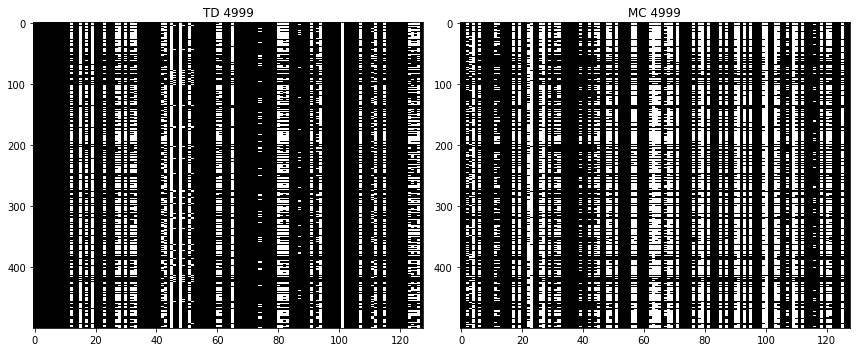

In [141]:
## Plot of all active features for test states 

chkpt_idx=4999
td_agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)
td_agent.load_model(td_model_path.format(chkpt_idx=chkpt_idx))
td_features = td_agent.get_features(test_states, add_bias=False)

mc_agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)
mc_agent.load_model(mc_model_path.format(chkpt_idx=chkpt_idx))
mc_features = mc_agent.get_features(test_states, add_bias=False)


fig = plt.figure(figsize=(14,6))
f, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].imshow(td_features > 0, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
axes[1].imshow(mc_features > 0, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
axes[0].set_title(f"TD {chkpt_idx}")

axes[1].set_title(f"MC {chkpt_idx}")


f.tight_layout()


In [142]:
def get_errors(agent):
    # returns a list of all errors on the test states
    errors = []
    for test_state, test_value in zip(test_states, test_values):
        pred = agent.get_prediction(test_state)
        errors.append(np.abs((pred - test_value)))
    return errors

errors = get_errors(td_agent)
errors = np.array(errors) / 150
# plt.scatter(np.arange(len(errors)), errors, marker='x', s=10)


# fig = plt.figure(figsize=(14,6))
# f, axes = plt.subplots(1, 2, figsize=(12,5))
# plt.imshow(errors.reshape(-1, 1), aspect='auto', cmap='seismic', interpolation='nearest')


[ 63 384 490 467 422 138 292 432 227  47 100 429 238 286 419 386 274 118 342  83  66 337 281  87 159 271  58  45 359 272 287 273 208 385 222 202 344 279 312 249 302 373 436 314  34  85  61  33 231 183 111 443  11  78 296  98  89  28 130 448 144 379 393 166 257 327  99  80   1 200 440 418 121 285
 102  82 244 383  24  51 186  25 214  90  75  95 468  40  79 456 399 252 141 400 188 245 131  69 299 495 230 197 114 262 295 424 417 392 348 165 324 313 460 254  49 177 388 341  86  57 164 483 463 469 223 378 189 488 136 259 270  96 351 428 174 309 253 408 363 320  71 201 185 478 420 148 397 181
 304 282 211 145 132 390 444 395 458 439 205 316 301 319 172 209  41 180 247 290  60 246 442 108 330  43  92  21 364 472  36 353   5 367 152 276 457 492 163 447 278 496 410 229  30 217 126 452 414 297 426 402  64 151 486 194  65 184  91 250 346 215 116 494 216 391 333   8 474 325 218 489 412 381
 162 142 380 484 203 366 329 150 277  17  94 499 280 235 129  10 113 157 446 204  67 139 449  56 149 481 352 

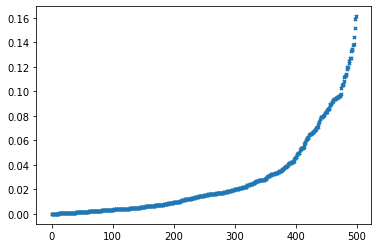

In [143]:
sort_idx = np.argsort(errors)
plt.scatter(np.arange(len(errors)), errors[sort_idx], marker='x', s=10)


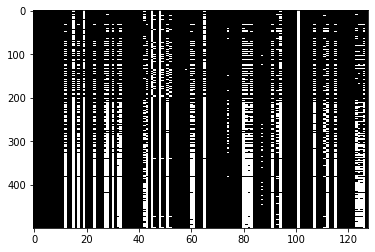

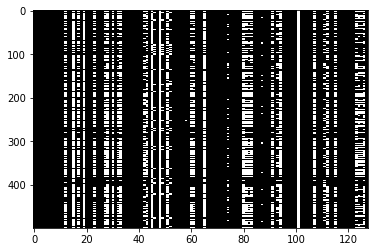

In [144]:
plt.imshow((td_features[sort_idx] > 0)[:], aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
plt.figure()
plt.imshow((td_features > 0)[:], aspect='auto', cmap=plt.cm.gray, interpolation='nearest')

AttributeError: 'Figure' object has no attribute 'set_title'

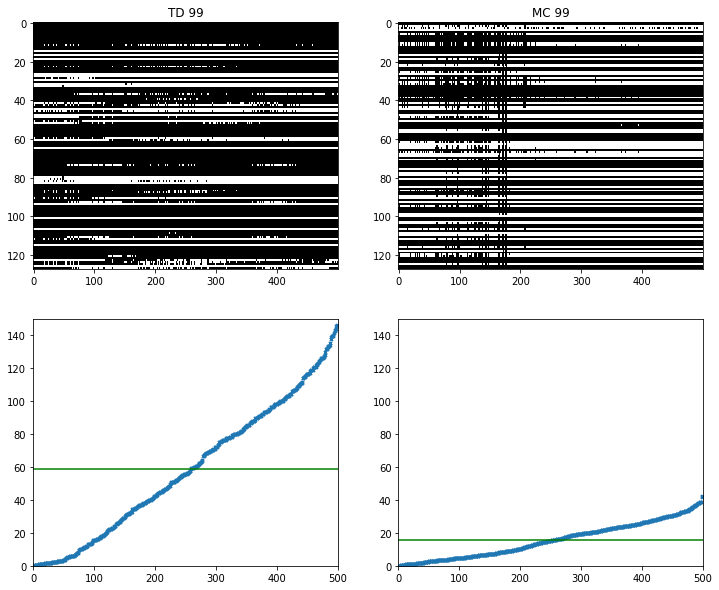

In [159]:

def get_sorted_feature_matrix(agent):
    # returns the sorted feature matrix and the sorted errors
    errors = np.array(get_errors(agent))
    features = agent.get_features(test_states, add_bias=False)
    sort_idx = np.argsort(errors)
    
    return features[sort_idx], errors[sort_idx]

def compare_TD_and_MC_feature_matrix(chkpt_idx):
    # plots the feature matrix and errors (sorted from lowest error to highest)
    # note the feature matrix is transposed to align with the errors
    td_agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)
    td_agent.load_model(td_model_path.format(chkpt_idx=chkpt_idx))

    mc_agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)
    mc_agent.load_model(mc_model_path.format(chkpt_idx=chkpt_idx))
    
    td_features, td_errors = get_sorted_feature_matrix(td_agent)
    mc_features, mc_errors = get_sorted_feature_matrix(mc_agent)
    
    f, axes = plt.subplots(2, 2, figsize=(12,10))

    # per example
    axes[0][0].imshow((td_features > 0).T, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
    axes[0][1].imshow((mc_features > 0).T, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
    axes[1][0].scatter(np.arange(len(td_errors)), td_errors, marker='x', s=10)
    axes[1][1].scatter(np.arange(len(mc_errors)), mc_errors, marker='x', s=10)
    axes[1][0].axhline(np.mean(td_errors), color='g')
    axes[1][1].axhline(np.mean(mc_errors), color='g')

    axes[1][0].set_ylim([0,150])
    axes[1][1].set_ylim([0,150])
    axes[1][0].set_xlim([0,500])
    axes[1][1].set_xlim([0,500])

    axes[0][0].set_title(f"TD {chkpt_idx}")
    axes[0][1].set_title(f"MC {chkpt_idx}")
    f.set_title(f'{model_path}')
    # for ax in axes:
    #     ax.set_ylim([0,200])
    #     # ax.set_xlim([0,0.5])
    #     ax.set_xlabel("fraction units active per example")
    #     ax.set_ylabel("number of examples (states)")
    f.tight_layout()

    

compare_TD_and_MC_feature_matrix(99)



# idxs = np.arange(0, 50)*100 + 99
# idxs = np.insert(idxs,0,0)
# print(idxs)


# for i in idxs:
#     compare_TD_and_MC_feature_matrix(i)
#     plt.savefig(f'gif/feature_matrix_{i}.png')
#     plt.close()
# print('done')

In [157]:
import imageio as iio

with iio.get_writer(f'feature_matrix.gif', mode="I", fps=3) as writer:
    for i in idxs:
        name = f"gif/feature_matrix_{i}.png"
        image = iio.imread(name)
        writer.append_data(image)

import pygifsicle
pygifsicle.optimize(f"feature_matrix.gif", f"feature_matrix.gif")       

/tmp/ipykernel_22633/2008300850.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(name)
gifsicle: warning: trivial adaptive palette (only 116 colors in source)
